# Predicting Taxi Pickups in NYC

In this notebook, I will explore k-nearest neighbor, linear and polynomial regression methods for predicting a quantitative variable. Specifically, I will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in files `dataset_1_train.txt` and `dataset_1_test.txt` as separate training and test sets. The first column in each file contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded during different days in Jan 2015 (randomly sampled across days and time of that day).

I will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pick ups at that time. The models will be fitted to the training set, and  evaluated on the test set. The performance of the models will be evaluated using the $MSE$ metric.

**Reference:** The topic and structure of this notebook comes from the Homework 4 of the *CS 109A, STAT 121A, AC 209A
Introduction to Data Science* class at Harvard. For more information see https://canvas.harvard.edu/courses/29726/assignments/172400 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

# Reading and Processing Data

In [2]:
#import the data
train_df = pd.read_csv('dataset_1_train.txt')
test_df = pd.read_csv('dataset_1_test.txt')

#Preview the training data
train_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [3]:
train_df.describe()

,TimeMin,PickupCount
count,250.000000,250.000000
mean,701.416000,32.780000
std,409.247928,18.910368
min,4.000000,1.000000
25%,381.500000,18.000000
50%,686.000000,32.000000
75%,1032.750000,44.000000
max,1438.000000,95.000000


In [4]:
# Normalizing training data
train_df['TrainMin'] = train_df['TimeMin'] / 1440 # 1440 represents 24 hours
test_df['TrainMin'] = test_df['TimeMin'] / 1440

# Part (0): EDA

Generate a scatter plot of the training data points, with the time of the day on the X-axis and the number of taxi pickups on the Y-axis. Does the pattern of taxi pickups make intuitive sense to you?

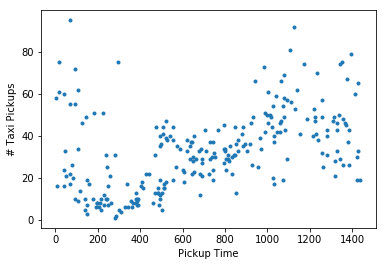

In [5]:
_ = plt.plot(train_df['TimeMin'], train_df['PickupCount'], marker='.', linestyle='none')
_ = plt.xlabel('Pickup Time')
_ = plt.ylabel('# Taxi Pickups')

plt.show()

**Observations:** Based on the scatter plot, the number of taxi pickups seems to be the highest during the morning and evenings.

# Part (a): k-Nearest Neighbors

We begin with k-Nearest Neighbors (k-NN), a non-parametric regression technique.

**Fit k-NN regression models:**


In [6]:
#Get our train and test data ready
x_train = np.array(train_df['TimeMin']).reshape(-1,1)
y_train = np.array(train_df['PickupCount']).reshape(-1,1)

x_test = np.array(test_df['TimeMin']).reshape(-1,1)
y_test = np.array(test_df['PickupCount']).reshape(-1,1)

# Create Regressor Model
knn = KNeighborsRegressor()

# Fit data to the model
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

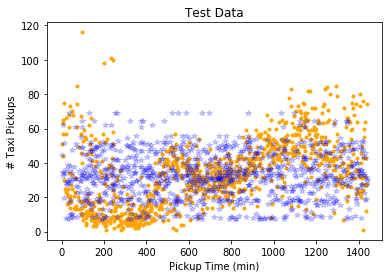

In [7]:
# Predict
train_predict = knn.predict(x_train)
test_predict = knn.predict(x_test)

# Plot
_ = plt.plot(x_test, y_test, marker='.', linestyle='none', color='orange')
_ = plt.plot(np.sort(x_test, axis=0), test_predict, '*', alpha=0.2, color='blue')
_ = plt.title('Test Data')
_ = plt.xlabel('Pickup Time (min)')
_ = plt.ylabel('# Taxi Pickups')


In [8]:
#MSE
train_MSE = np.mean((y_train - train_predict)**2)
test_MSE = np.mean((y_test - test_predict)**2)

print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

The train MSE is 180.90624, the test MSE is 228.58151999999998


**Observations:** By default, 5 nearest neighbors were used which doesn't do a good job at predicting on the test data

**Visualize the fitted models**

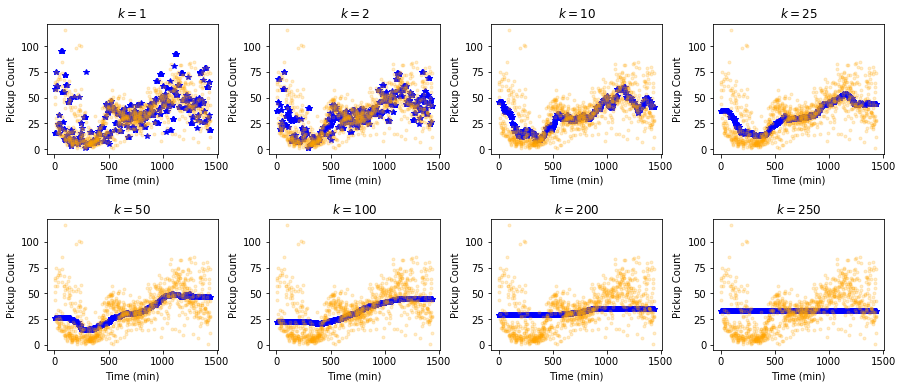

In [9]:
k_neighbors = [1, 2, 10, 25, 50, 100, 200, 250]
fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()

train_MSEs = []
test_MSEs = []

for i, k in enumerate(k_neighbors):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train, y_train)
    
    #Predict from Train and Test Data
    train_predict = knn.predict(x_train)
    test_predict = knn.predict(x_test)
    
    # MSEs for Train and Test Data
    train_MSE = np.mean((y_train - train_predict)**2)
    test_MSE = np.mean((y_test - test_predict)**2)
    
    #Save MSEs
    train_MSEs.append(train_MSE)
    test_MSEs.append(test_MSE)
    
    # Plot
    axs[i].plot(x_test, test_predict, '*', label='Predicted', color='blue')
    axs[i].plot(x_test, y_test, '.', alpha=0.2, label='Actual', color='orange')
    
    
    # Set labels
    axs[i].set_title("$k = " + str(k) + "$")
    axs[i].set_xlabel('Time (min)')
    axs[i].set_ylabel('Pickup Count')

**Observations:** Based on the plots, the ideal k seems to be around 50. This will give us the best fit for the data. Anything smaller seems to overfit the data and anything larger seems to generalize too much

**Evaluate**

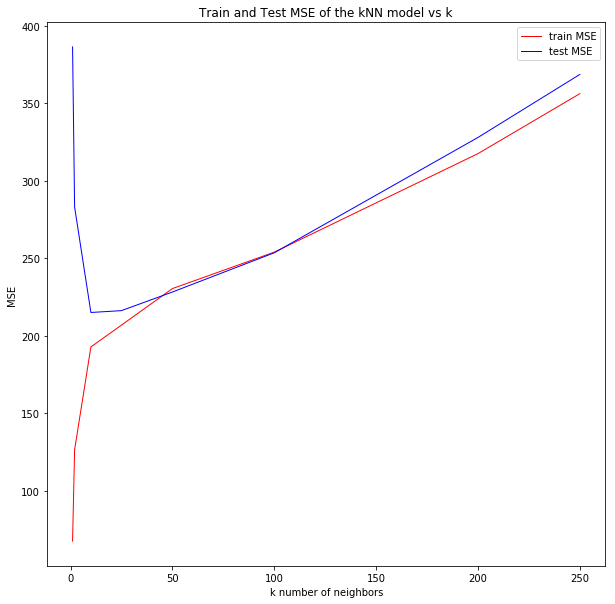

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(k_neighbors, train_MSEs, color='red', linewidth=1.0, label='train MSE')
ax.plot(k_neighbors, test_MSEs, color='blue', linewidth=1.0, label='test MSE')


ax.set_xlabel('k number of neighbors')
ax.set_ylabel('MSE')
ax.set_title('Train and Test MSE of the kNN model vs k')
ax.legend(loc='best')

# Part (b): Simple Linear Regression

We next consider parametric approaches for regression, starting with simple linear regression, which assumes that the response variable has a linear relationship with the predictor. Do you see any advantages in using a parametric regression model over k-NN regression?

We suggest that you use the `statsmodels` module for linear regression. This module has built-in functions to summarize the results of regression, and to compute confidence intervals for estimated regression parameters. Create a `OLS` class instance, use the `fit` method in the instance for fitting a linear regression model, and use the `predict` method to make predictions. To include an intercept term in the regression model, you will need to append a column of 1's to the array of predictors using the `sm.add_constant` method. The `fit` method returns a `results` instance. Use the  `results.summary` method to obtain a summary of the regression fit, the `results.params` attribute to get the estimated regression parameters, and the `conf_int` method to compute confidence intervals for the estimated parameters. You may use the `r2_score` function to compute $R^2$.

Using the suggested built-in functions, answer the following questions:

- Fit a linear regression model to the training set, and evaluate its $R^2$ value on both the training and test sets (you may notice something peculiar about how they compare). 
- How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression in Part (a)?

- Compute confidence intervals:
    - Print the slope and intercept values for the fitted linear model. What does the sign of the slope convey about the data?
    - Compute the 95% confidence interval for the slope and intercept. Based on this information, do you consider the estimates of the model parameters to be reliable?
    - Do you expect a 99% confidence interval for the slope and intercept to be tighter or looser than the 95% confidence intervals? Briefly explain your answer.

- Analyze residual plots:
    - Make a plot of the residuals ${e} = y - \hat{y}$ of the model on the training set as a function of the predictor variable $x$ (i.e. time of day). Draw a horizontal line denoting the zero residual value on the Y-axis.
    - Using this residual plot, comment on whether the assumption of linearity is valid for this data.

# Part (c): Polynomial Regression

We proceed to higher-order polynomial models for regression:

- By visual inspection, what polynomial degree do you think would provide the best fit for the data?

- At the start of this assignment, we had advised you to normalize the time predictor in the training and test sets to a value in [0,1], and noted that this would be helpful in fitting polynomial regression models. Had the time predictor not been normalized, what difficulties in implementing polynomial regression may have occurred?

- Fit polynomial regression models of degrees 2, 3, 10, 25 and 50 to the training set, and generate visualizations of the fitted models (in the same figure, plot the predicted value from all models as a function of time). 

- Evaluate the $R^2$ value of the fitted models on both the training and test sets. Does a high training $R^2$ value necessarily indicate a high test $R^2$ value? How do the test $R^2$ values from the different polynomial models compare with the test $R^2$ from simple linear regression in Part (b), and the best test $R^2$ from k-NN regression in Part (a)?

- Generate residual plots for the different polynomial regression models (plot of residuals on training set vs. time). How does the increase in polynomial degree effect the residual plots?

*Hint:* You may use the `PolynomialFeatures` class to include polynomial terms in the regression model.

# Part (d): Summarize Results
In a brief paragraph (8 or fewer sentences), summarize which of the models seen above you would choose to predict the number of taxi cab pick-ups at any specific time of day.  Be sure to explain your choice. Interpret the model you choose, including which predictors are significant and provide and interpret the CIs for their coefficients (if you choose a regression model). How well does you model predict the number of taxi cab pick-ups?  How would you improve this model even further?  Feel free to refer to visual(s) above or provide a new one to make your case.



---- 


# APCOMP209a - Homework Question

Read Sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, we have a number of cleaned images of people's faces. The model leverages the concept that "patterns from a single-object class lie on a linear subspace" and the fact that linear regression can be thought of as an orthogonal projection of the response vector (Y) onto the subspace spanned by the columns of the predictor matrix (X).

### Question 1
Consider a space in $\mathbb{R}^5$, with two subspaces $S_0 \subset \mathbb{R}^5$ and $S_1 \subset \mathbb{R}^5$. For simplicity, let us consider the case where the subspace $S_0$ is spanned by the vectors $v_{00} = [1,0,0,0,0]^T$, $v_{01} =[0,1,0,0,0]^T$ and the subspace $S_1$ is spanned by the vectors $v_{10} = [0,0,0,1,0]^T$ and $v_{11} = [0,0,0,0,1]^T$. 

Now let us assume that we have a dataset that consists of labeled vectors in subspaces $S_0$ and $S_1$ respectively. Our task here is to use the data in the training dataset to classify an unknown vector into either $S_0$ or $S_1$.

Let us consider the case where we construct a predictive matrix $\mathbf{X}$ from the 'training' data for which we know the labels (note: is not meant to match $S_0$ and $S_1$ above).

```
dataset = np.array([
            [1,0,0,0,0],
            [1,1,0,0,0],
            [0,0,0,1,1],
            [0,0,0,1,0],
            ])
labels = np.array([0,0,1,1])
```

(Briefly notice that the training data probably doesn't consist of vectors that are orthonormal in spanning $S_0$ or $S_1$).

And we have an unknown vector, for which we want clasify as either a noisy example of a vector in either $S_0$ or $S_1$: ```y_0 = np.array([2,10,1,0,0])```.

In [11]:
# starter code
dataset = np.array([
            [1,0,0,0,0],
            [1,1,0,0,0],
            [0,0,0,1,1],
            [0,0,0,1,0],
            ])
labels = np.array([0,0,1,1])
y_0 = np.array([2,10,1,0,0])

#### Question 1a
Recall the solution for the Least Squares problem and the 'hat' matrix $\mathbf{H}$. Consider the case when $Y$ lies in the same subspace as the columns of $\mathbf{X}$. In this case, how accurate should the prediction of $\hat{Y}$ be?

#### Question 1b
Given the projection of $Y$ onto the space spanned by the columns of the X matrix. We can analyse the significance of the different predictor vectors (i.e. the building blocks that are used to reconstrct the $\hat{Y}$ vector). Discuss how this may help one when analysing a classification decision by the model.

#### Question 1c
As discussed in the linked paper, we have data that has vectors that are classified into one subspace or another (our training dataset). We can use the projection interpretation of linear regression to make a classification decision of a new (unseen) vector into either $S_0$ or $S_1$. In other words, construct X matrices from the known vectors, and project the unknown vector onto the subspaces spanned by the various X matrices using the "hat" interpretation of linear regression. To do classification, we can calculate the minimum euclidean distance ($L_2$ norm) between the original vector and the projection. Use this method to classify ```y_0``` as belonging to either $S_0$ or $S_1$.

**Feel free to run this same example on the face data presented in the paper - you will be doing this for next week's homework regardless**

#### Question 1d (unrelated to the parts above)

Explicitly derive the relationship between the F-statistic (from the usual F test) and the $R^2$ measure in multiple linear regression (i.e. write the F-statistic of a multiple linear regression model in terms of the $R^2$ of the same model).